In [28]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from pyswarms.single import GlobalBestPSO, LocalBestPSO
from pyswarms.utils.functions.single_obj import sphere, rastrigin, ackley, rosenbrock
import optuna
import pandas as pd

# Define benchmark functions and bounds
benchmark_functions = {
    "Sphere": sphere,
    "Rastrigin": rastrigin,
    "Ackley": ackley,
    "Rosenbrock": rosenbrock
}

bounds = {
    "Sphere": (-5.12, 5.12),
    "Rastrigin": (-5.12, 5.12),
    "Ackley": (-32.768, 32.768),
    "Rosenbrock": (-5, 10)
}

# Run PSO experiments for different topologies and settings
def run_pso_experiments(func_name, func, bounds, n_particles=50, dimensions=30, iterations=200, use_optimized=False):
    """Run PSO experiments with GlobalBestPSO and LocalBestPSO."""
    results = {}

    # Define default PSO parameters
    default_params = {'c1': 1.5, 'c2': 1.5, 'w': 0.7}

    # Optimize parameters using Optuna if requested
    if use_optimized:
        def objective(trial):
            c1 = trial.suggest_float("c1", 0.5, 2.5)
            c2 = trial.suggest_float("c2", 0.5, 2.5)
            w = trial.suggest_float("w", 0.4, 0.9)
            optimizer = GlobalBestPSO(
                n_particles=n_particles,
                dimensions=dimensions,
                options={"c1": c1, "c2": c2, "w": w},
                bounds=(np.array([bounds[0]] * dimensions), np.array([bounds[1]] * dimensions))
            )
            cost, _ = optimizer.optimize(func, iters=50, verbose=False)
            return cost

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=10)
        optimized_params = study.best_params
    else:
        optimized_params = default_params

    # Run GlobalBestPSO (Default and Optimized)
    for setting, params in [("Default", default_params), ("Optimized", optimized_params)]:
        optimizer = GlobalBestPSO(
            n_particles=n_particles,
            dimensions=dimensions,
            options=params,
            bounds=(np.array([bounds[0]] * dimensions), np.array([bounds[1]] * dimensions))
        )
        cost, _ = optimizer.optimize(func, iters=iterations, verbose=False)
        results[f"Gbest {setting}"] = optimizer.cost_history

    # Run LocalBestPSO (Default and Optimized)
    for setting, params in [("Default", default_params), ("Optimized", optimized_params)]:
        optimizer = LocalBestPSO(
            n_particles=n_particles,
            dimensions=dimensions,
            options=params,
            bounds=(np.array([bounds[0]] * dimensions), np.array([bounds[1]] * dimensions))
        )
        cost, _ = optimizer.optimize(func, iters=iterations, verbose=False)
        results[f"Lbest {setting}"] = optimizer.cost_history

    return results

# Collect results for all benchmark functions
all_results = {}
for func_name, func in benchmark_functions.items():
    print(f"Running experiments for {func_name}...")
    all_results[func_name] = run_pso_experiments(func_name, func, bounds[func_name])

# Plot results
fig, axs = plt.subplots(len(benchmark_functions), 1, figsize=(10, 20))
fig.subplots_adjust(hspace=0.5)
for ax, (func_name, results) in zip(axs, all_results.items()):
    for setting, cost_history in results.items():
        ax.plot(range(len(cost_history)), cost_history, label=setting)
    ax.set_title(f"{func_name} Function: Hyperparameter Comparison", fontsize=14)
    ax.set_xlabel("Iterations", fontsize=12)
    ax.set_ylabel("Cost", fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True)

plt.show()

# Summarize final costs in a table
summary_data = {
    func_name: {setting: cost_history[-1] for setting, cost_history in results.items()}
    for func_name, results in all_results.items()
}
summary_df = pd.DataFrame(summary_data).T
summary_df.index.name = "Function"
summary_df.columns.name = "Configuration"

print("\nFinal Cost Summary:")
print(summary_df)


Running experiments for Sphere...


KeyError: 'k'

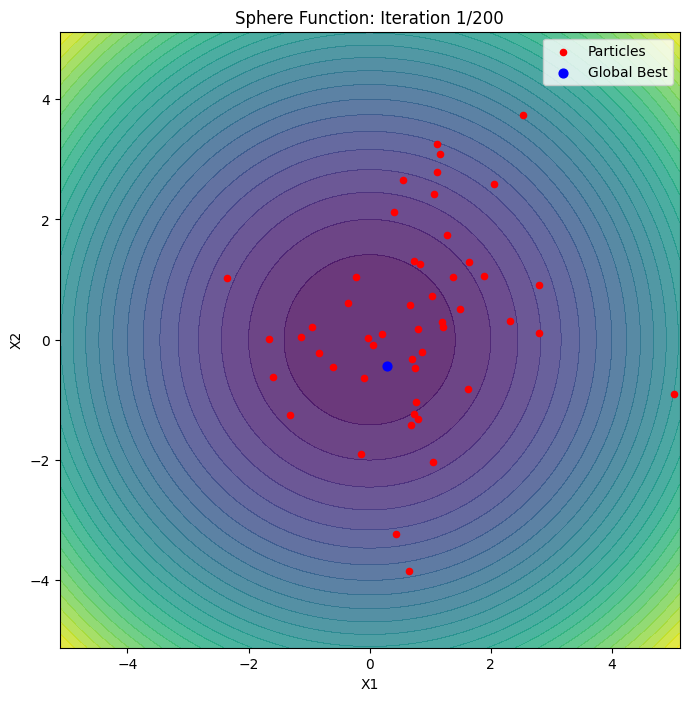

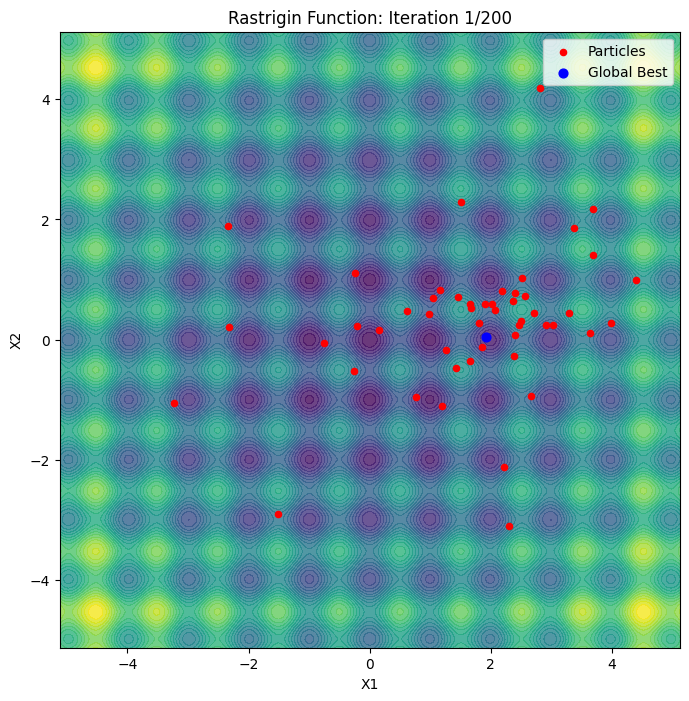

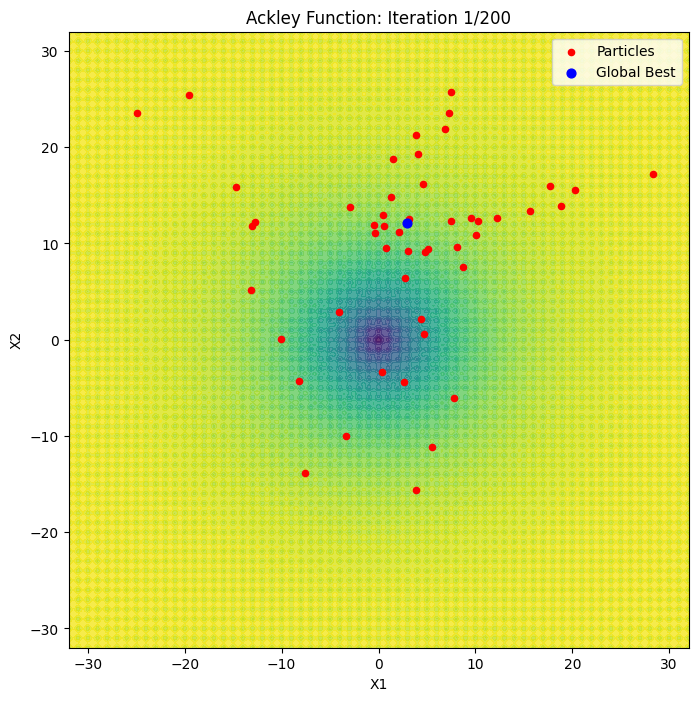

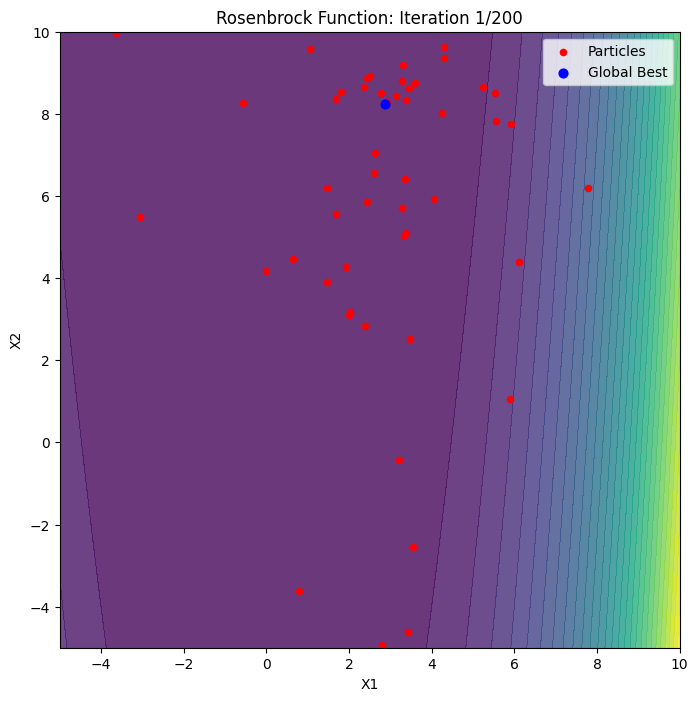

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from pyswarms.single import GlobalBestPSO
from pyswarms.utils.functions.single_obj import sphere, rastrigin, ackley, rosenbrock
import matplotlib.animation as animation

# ---------------------------
# 1) Benchmark functions and bounds
# ---------------------------
benchmark_functions = {
    "Sphere":     (sphere,    (-5.12,  5.12)),
    "Rastrigin":  (rastrigin, (-5.12,  5.12)),
    "Ackley":     (ackley,    (-32,    32)),
    "Rosenbrock": (rosenbrock,(-5,     10))
}

# ---------------------------
# 2) PSO Parameters
# ---------------------------
dimensions   = 2
n_particles  = 50
iterations   = 200
options      = {"c1": 1.5, "c2": 1.5, "w": 0.7}

# ---------------------------
# 3) Run PSO manually, storing history each iteration
# ---------------------------
def run_optimization(func, bounds):
    """
    Runs GlobalBestPSO for 'iterations' steps, one iteration at a time.
    Returns:
      positions:      shape = (iterations, n_particles, dimensions)
      gbest_positions: shape = (iterations, dimensions)
    """
    optimizer = GlobalBestPSO(
        n_particles = n_particles,
        dimensions  = dimensions,
        options     = options,
        bounds      = (
            np.array([bounds[0]] * dimensions),
            np.array([bounds[1]] * dimensions)
        ),
    )

    pos_history   = []
    gbest_history = []

    # Do 1 iteration at a time, record swarm each time
    for _ in range(iterations):
        cost, pos = optimizer.optimize(func, iters=1, verbose=False)
        pos_history.append(optimizer.swarm.position.copy())
        gbest_history.append(optimizer.swarm.best_pos.copy())

    return np.array(pos_history), np.array(gbest_history)

# ---------------------------
# 4) Create a dynamic animation for one function
# ---------------------------
def create_animation(func_name, func, bounds):
    # Run the optimization and get full iteration history
    positions, gbest_positions = run_optimization(func, bounds)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(bounds[0], bounds[1])
    ax.set_ylim(bounds[0], bounds[1])
    ax.set_title(f"{func_name} Function: Swarm Movement", fontsize=14)
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")

    # Precompute contour for speed
    grid_size = 300
    x = np.linspace(bounds[0], bounds[1], grid_size)
    y = np.linspace(bounds[0], bounds[1], grid_size)
    X, Y = np.meshgrid(x, y)
    Z = func(np.c_[X.ravel(), Y.ravel()]).reshape(X.shape)
    ax.contourf(X, Y, Z, levels=30, cmap="viridis", alpha=0.8)

    # Initialize scatter plots
    scat = ax.scatter([], [], c="red",  s=20, label="Particles")
    best_scat = ax.scatter([], [], c="blue", s=40, label="Global Best")

    # The update function for animation
    def update(frame):
        ax.set_title(f"{func_name} Function: Iteration {frame+1}/{iterations}")
        scat.set_offsets(positions[frame])
        best_scat.set_offsets(gbest_positions[frame])
        return scat, best_scat

    # Create the animation
    ani = animation.FuncAnimation(
        fig,
        update,
        frames=iterations,
        interval=100,
        blit=True
    )

    ax.legend(loc="upper right")
    plt.show()

# ---------------------------
# 5) Animate for all benchmark functions, one after another
# ---------------------------
for func_name, (func, bounds) in benchmark_functions.items():
    create_animation(func_name, func, bounds)


Running experiments for Sphere...
Running experiments for Rastrigin...
Running experiments for Ackley...
Running experiments for Rosenbrock...


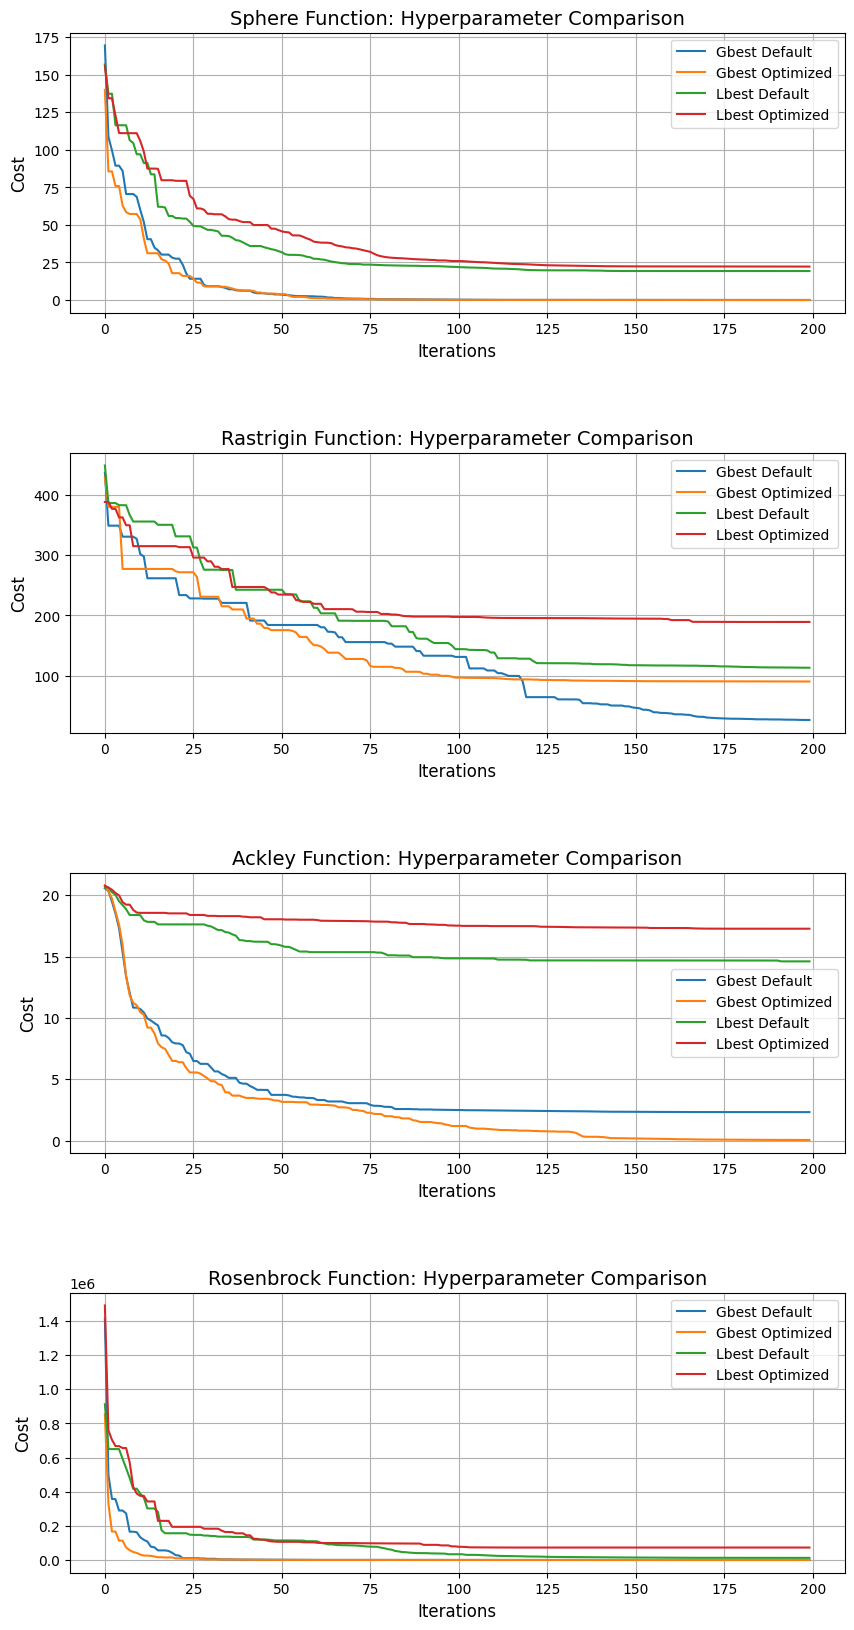


Final Cost Summary:
Configuration  Gbest Default  Gbest Optimized  Lbest Default  Lbest Optimized
Function                                                                     
Sphere              0.000640         0.000423      19.288562        22.257344
Rastrigin          26.808651        90.584557     113.393994       189.254396
Ackley              2.316720         0.042949      14.612608        17.277305
Rosenbrock        128.619179        93.321077   12508.833188     73007.304819


In [32]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from pyswarms.single import GlobalBestPSO, LocalBestPSO
from pyswarms.utils.functions.single_obj import sphere, rastrigin, ackley, rosenbrock
import optuna
import pandas as pd

# Define benchmark functions and their valid bounds
benchmark_functions = {
    "Sphere": sphere,
    "Rastrigin": rastrigin,
    "Ackley": ackley,
    "Rosenbrock": rosenbrock
}

bounds = {
    "Sphere": (-5.12, 5.12),
    "Rastrigin": (-5.12, 5.12),
    "Ackley": (-32, 32),  # Adjusted for Ackley's strict validation
    "Rosenbrock": (-5, 10)
}

# Run PSO experiments for different topologies and settings
def run_pso_experiments(func_name, func, bounds, n_particles=50, dimensions=30, iterations=200, use_optimized=False):
    """Run PSO experiments with GlobalBestPSO and LocalBestPSO."""
    results = {}

    # Define default PSO parameters
    default_params = {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
    local_pso_params = {'c1': 1.5, 'c2': 1.5, 'w': 0.7, 'k': 3, 'p': 2}  # LocalBestPSO requires 'k' and 'p'
    velocity_clamp = (-4, 4)  # Velocity clamping to prevent excessive movement
    bh_strategy = "nearest"  # Boundary handling strategy to ensure particles stay within bounds

    # Optimize parameters using Optuna if requested
    if use_optimized:
        def objective(trial):
            c1 = trial.suggest_float("c1", 0.5, 2.5)
            c2 = trial.suggest_float("c2", 0.5, 2.5)
            w = trial.suggest_float("w", 0.4, 0.9)
            optimizer = GlobalBestPSO(
                n_particles=n_particles,
                dimensions=dimensions,
                options={"c1": c1, "c2": c2, "w": w},
                bounds=(np.array([bounds[0]] * dimensions), np.array([bounds[1]] * dimensions)),
                velocity_clamp=velocity_clamp,
                bh_strategy=bh_strategy
            )
            cost, _ = optimizer.optimize(func, iters=50, verbose=False)
            return cost

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=10)
        optimized_params = study.best_params
        local_pso_params.update({'c1': optimized_params['c1'], 'c2': optimized_params['c2'], 'w': optimized_params['w']})
    else:
        optimized_params = default_params

    # Run GlobalBestPSO (Default and Optimized)
    for setting, params in [("Default", default_params), ("Optimized", optimized_params)]:
        optimizer = GlobalBestPSO(
            n_particles=n_particles,
            dimensions=dimensions,
            options=params,
            bounds=(np.array([bounds[0]] * dimensions), np.array([bounds[1]] * dimensions)),
            velocity_clamp=velocity_clamp,
            bh_strategy=bh_strategy
        )
        cost, _ = optimizer.optimize(func, iters=iterations, verbose=False)
        results[f"Gbest {setting}"] = optimizer.cost_history

    # Run LocalBestPSO (Default and Optimized)
    for setting, params in [("Default", local_pso_params), ("Optimized", local_pso_params)]:
        optimizer = LocalBestPSO(
            n_particles=n_particles,
            dimensions=dimensions,
            options=params,
            bounds=(np.array([bounds[0]] * dimensions), np.array([bounds[1]] * dimensions)),
            velocity_clamp=velocity_clamp,
            bh_strategy=bh_strategy
        )
        cost, _ = optimizer.optimize(func, iters=iterations, verbose=False)
        results[f"Lbest {setting}"] = optimizer.cost_history

    return results

# Collect results for all benchmark functions
all_results = {}
for func_name, func in benchmark_functions.items():
    print(f"Running experiments for {func_name}...")
    all_results[func_name] = run_pso_experiments(func_name, func, bounds[func_name])

# Plot results
fig, axs = plt.subplots(len(benchmark_functions), 1, figsize=(10, 20))
fig.subplots_adjust(hspace=0.5)
for ax, (func_name, results) in zip(axs, all_results.items()):
    for setting, cost_history in results.items():
        ax.plot(range(len(cost_history)), cost_history, label=setting)
    ax.set_title(f"{func_name} Function: Hyperparameter Comparison", fontsize=14)
    ax.set_xlabel("Iterations", fontsize=12)
    ax.set_ylabel("Cost", fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True)

plt.show()

# Summarize final costs in a table
summary_data = {
    func_name: {setting: cost_history[-1] for setting, cost_history in results.items()}
    for func_name, results in all_results.items()
}
summary_df = pd.DataFrame(summary_data).T
summary_df.index.name = "Function"
summary_df.columns.name = "Configuration"

print("\nFinal Cost Summary:")
print(summary_df)



[Results: Sphere]
  Gbest final cost: 0.000000, position: [3.09971842e-04 2.06004977e-05]
  Lbest final cost: 0.000000, position: [-1.51099535e-04  3.16895005e-05]


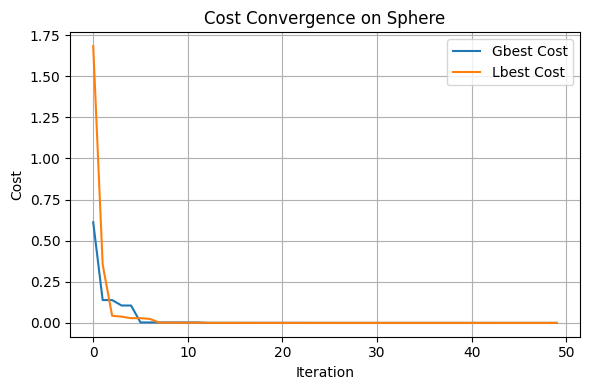

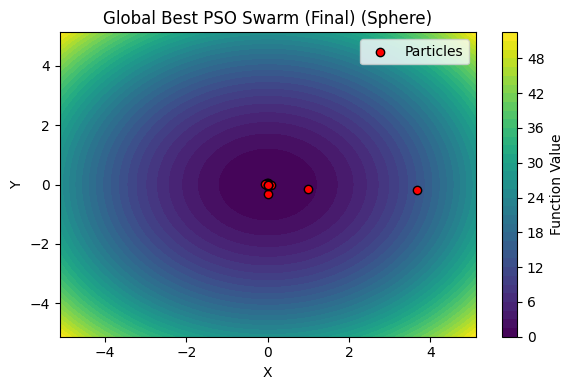

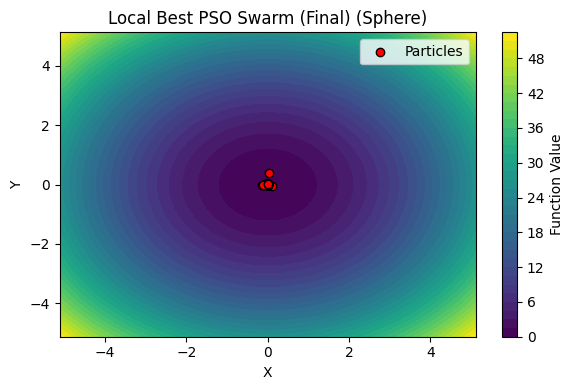


[Results: Rastrigin]
  Gbest final cost: 0.000164, position: [-0.00053603 -0.00073447]
  Lbest final cost: 0.994963, position: [ 7.60451597e-05 -9.95069940e-01]


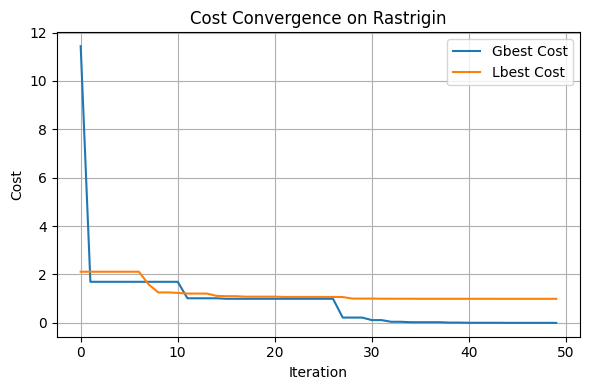

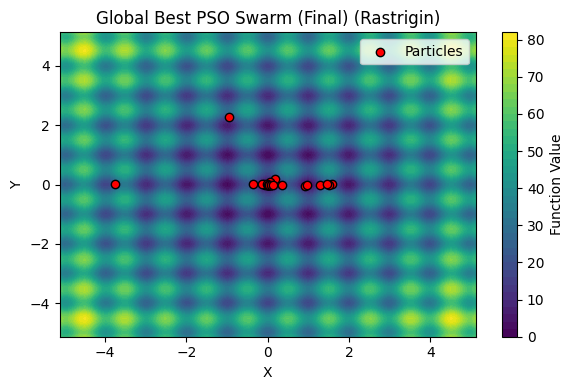

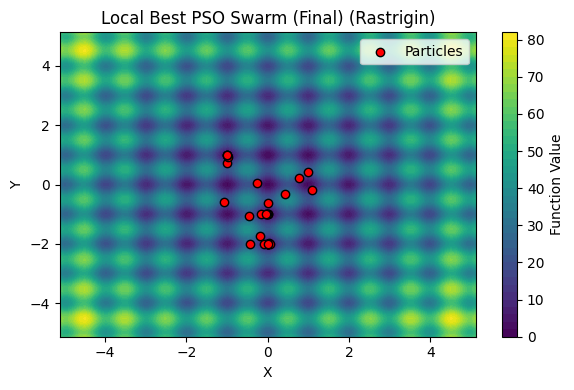


[Results: Ackley]
  Gbest final cost: 0.000912, position: [ 0.00026716 -0.00017875]
  Lbest final cost: 0.000081, position: [ 1.93405702e-05 -2.11308446e-05]


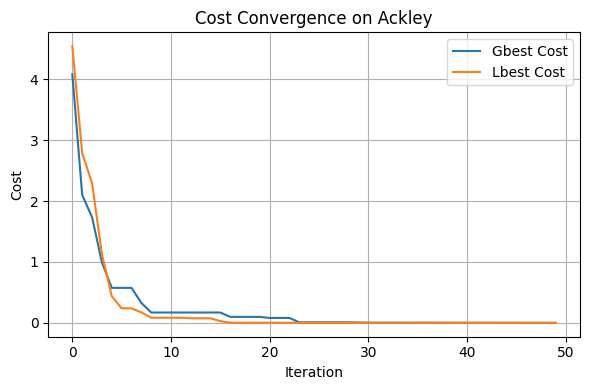

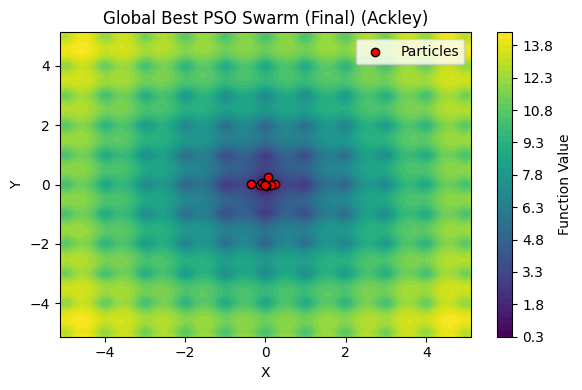

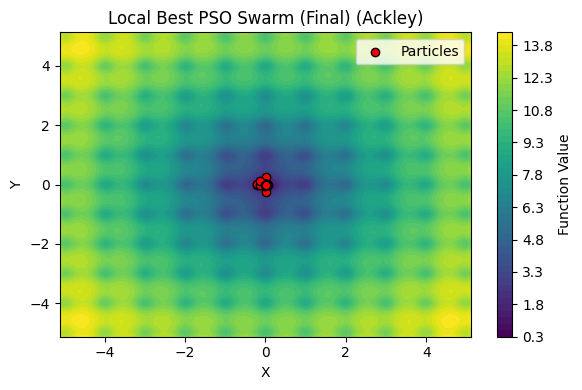


[Results: Rosenbrock]
  Gbest final cost: 0.000248, position: [1.01169797 1.02458497]
  Lbest final cost: 0.000237, position: [0.99060456 0.98007752]


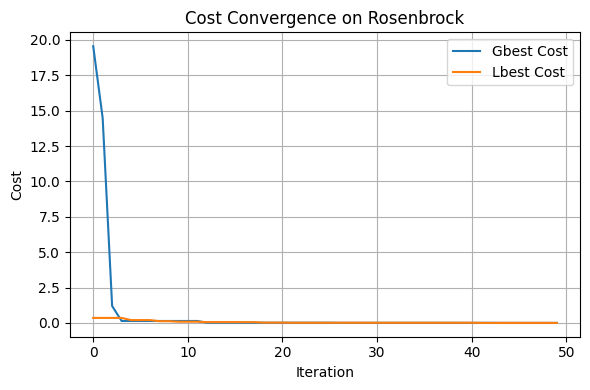

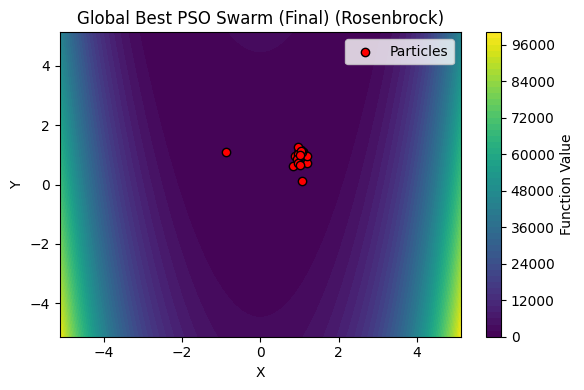

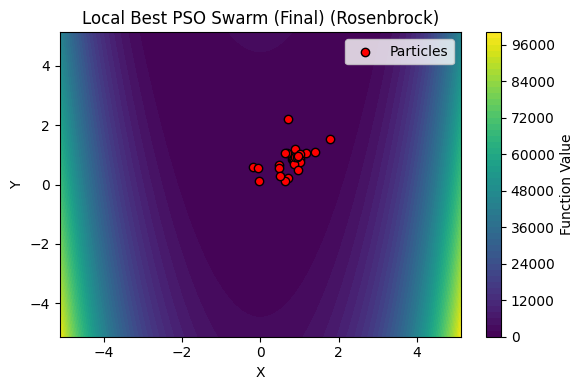


================= SUMMARY OF EXPERIMENT RESULTS =================
Function: Sphere
  Gbest final cost : 0.000000
  Lbest final cost : 0.000000
---------------------------------------------------------------
Function: Rastrigin
  Gbest final cost : 0.000164
  Lbest final cost : 0.994963
---------------------------------------------------------------
Function: Ackley
  Gbest final cost : 0.000912
  Lbest final cost : 0.000081
---------------------------------------------------------------
Function: Rosenbrock
  Gbest final cost : 0.000248
  Lbest final cost : 0.000237
---------------------------------------------------------------


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pyswarms as ps
from pyswarms.utils.functions.single_obj import sphere, rastrigin, ackley

##############################################################################
# 1. Define or import benchmark functions
##############################################################################
def rosenbrock(x):
    """
    Rosenbrock function in n dimensions.
    x is a 2D array: (n_particles, dimensions).
    Returns a 1D array of cost values (one per particle).
    """
    return np.sum(
        100.0 * (x[:,1:] - x[:,:-1]**2.0)**2.0 + (1 - x[:,:-1])**2.0,
        axis=1
    )

benchmark_functions = {
    "Sphere"    : sphere,
    "Rastrigin" : rastrigin,
    "Ackley"    : ackley,
    "Rosenbrock": rosenbrock,
}

##############################################################################
# 2. PSO Parameters and Bounds
##############################################################################
options = {
    'c1': 1.5,   # cognitive
    'c2': 1.5,   # social
    'w':  0.7,   # inertia weight
    'k':  5,     # for LocalBestPSO: number of neighbors
    'p':  2      # for LocalBestPSO: Euclidean distance
}

n_particles = 30
max_iter    = 50
dimensions  = 2

# Example bounds for typical functions in 2D:
min_bounds = [-5.12]*dimensions
max_bounds = [ 5.12]*dimensions
bounds = (min_bounds, max_bounds)

##############################################################################
# 3. Plot Helpers
##############################################################################
def plot_cost_history(cost_history_g, cost_history_l, func_name):
    """
    Plots convergence curves for GlobalBestPSO and LocalBestPSO.
    """
    plt.figure(figsize=(6,4))
    plt.plot(cost_history_g, label='Gbest Cost')
    plt.plot(cost_history_l, label='Lbest Cost')
    plt.title(f"Cost Convergence on {func_name}")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_2d_contour_and_swarm(func, func_name, bounds, positions, title="Swarm Final Positions"):
    """
    Plots a 2D contour of 'func' along with final swarm positions.
    'positions' should have shape (n_particles, 2).
    """
    if positions is None or len(positions.shape) < 2 or positions.shape[1] != 2:
        return  # Only works for 2D problems

    x_min, x_max = bounds[0][0], bounds[1][0]
    y_min, y_max = bounds[0][1], bounds[1][1]

    resolution = 100
    x_vals = np.linspace(x_min, x_max, resolution)
    y_vals = np.linspace(y_min, y_max, resolution)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Evaluate 'func' on the grid: shape => (num_points, dimensions)
    xy_grid = np.vstack([X.ravel(), Y.ravel()]).T
    Z = func(xy_grid).reshape(X.shape)

    plt.figure(figsize=(6,4))
    cp = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(cp, label='Function Value')
    plt.title(f"{title} ({func_name})")
    plt.xlabel('X')
    plt.ylabel('Y')

    # Plot final swarm positions
    plt.scatter(
        positions[:, 0],
        positions[:, 1],
        c='red', edgecolors='black',
        label='Particles'
    )
    plt.legend()
    plt.tight_layout()
    plt.show()

##############################################################################
# 4. Experiment Runner
##############################################################################
def run_experiment(func, func_name, bounds=None):
    """
    Runs both GlobalBestPSO and LocalBestPSO on 'func'.
    Returns final costs, positions, and cost histories.
    """
    # --- Global Best PSO ---
    gbest_optimizer = ps.single.GlobalBestPSO(
        n_particles=n_particles,
        dimensions=dimensions,
        options=options,
        bounds=bounds
    )
    gbest_cost, gbest_pos = gbest_optimizer.optimize(func, iters=max_iter, verbose=False)
    gbest_history = gbest_optimizer.cost_history
    # Final swarm positions from pos_history
    if gbest_optimizer.pos_history:
        gbest_swarm_positions = gbest_optimizer.pos_history[-1]  # last iteration
    else:
        gbest_swarm_positions = None

    # --- Local Best PSO ---
    lbest_optimizer = ps.single.LocalBestPSO(
        n_particles=n_particles,
        dimensions=dimensions,
        options=options,
        bounds=bounds
    )
    lbest_cost, lbest_pos = lbest_optimizer.optimize(func, iters=max_iter, verbose=False)
    lbest_history = lbest_optimizer.cost_history
    if lbest_optimizer.pos_history:
        lbest_swarm_positions = lbest_optimizer.pos_history[-1]
    else:
        lbest_swarm_positions = None

    print(f"\n[Results: {func_name}]")
    print(f"  Gbest final cost: {gbest_cost:.6f}, position: {gbest_pos}")
    print(f"  Lbest final cost: {lbest_cost:.6f}, position: {lbest_pos}")

    return {
        'gbest_cost'   : gbest_cost,
        'gbest_pos'    : gbest_pos,
        'gbest_history': gbest_history,
        'gbest_swarm'  : gbest_swarm_positions,
        'lbest_cost'   : lbest_cost,
        'lbest_pos'    : lbest_pos,
        'lbest_history': lbest_history,
        'lbest_swarm'  : lbest_swarm_positions
    }

##############################################################################
# 5. Main Script
##############################################################################
if __name__ == "__main__":
    results = {}

    for func_name, func in benchmark_functions.items():
        outcome = run_experiment(func, func_name, bounds=bounds)
        results[func_name] = outcome

        # Plot cost convergence for this function
        plot_cost_history(
            outcome['gbest_history'],
            outcome['lbest_history'],
            func_name
        )

        # If in 2D, plot the contour + final swarm positions
        if dimensions == 2:
            plot_2d_contour_and_swarm(
                func,
                func_name,
                bounds,
                outcome['gbest_swarm'],
                title="Global Best PSO Swarm (Final)"
            )
            plot_2d_contour_and_swarm(
                func,
                func_name,
                bounds,
                outcome['lbest_swarm'],
                title="Local Best PSO Swarm (Final)"
            )

    # Summary
    print("\n================= SUMMARY OF EXPERIMENT RESULTS =================")
    for func_name, info in results.items():
        print(f"Function: {func_name}")
        print(f"  Gbest final cost : {info['gbest_cost']:.6f}")
        print(f"  Lbest final cost : {info['lbest_cost']:.6f}")
        print("---------------------------------------------------------------")



[Results: Sphere]
  Gbest final cost: 0.000000, position: [-3.04195758e-05 -1.17266899e-05]
  Lbest final cost: 0.000000, position: [-1.72356611e-05 -1.51531905e-04]


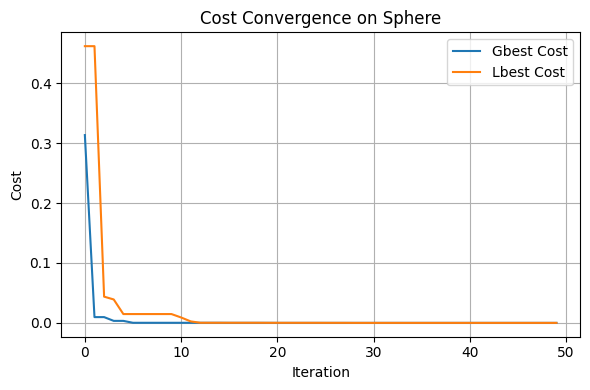

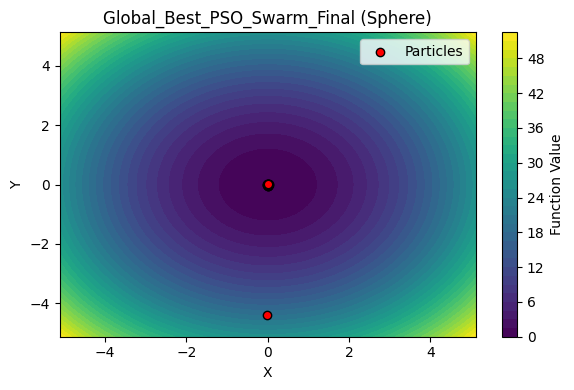

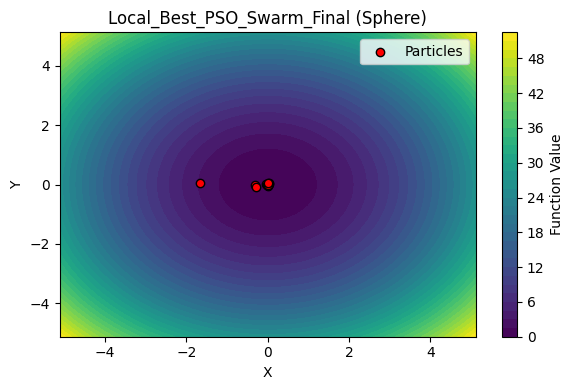


[Results: Rastrigin]
  Gbest final cost: 0.000014, position: [-0.0002268  -0.00013697]
  Lbest final cost: 0.027470, position: [0.00026911 0.0117666 ]


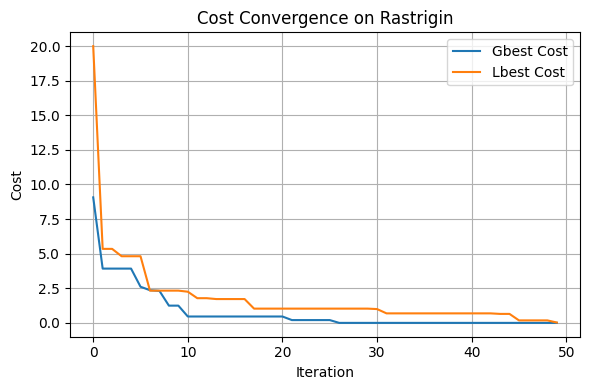

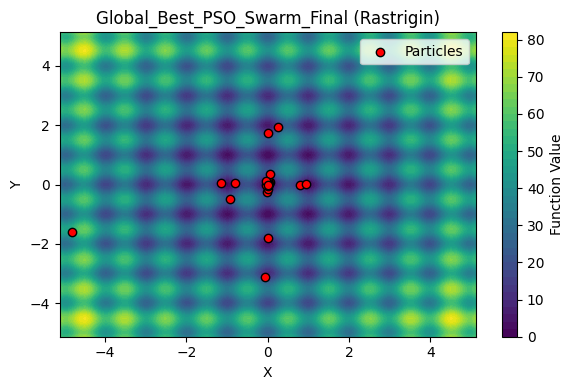

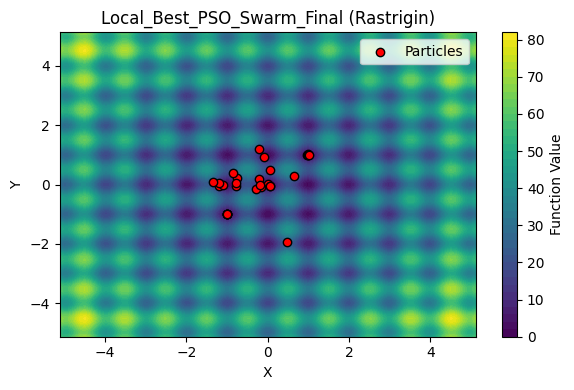


[Results: Ackley]
  Gbest final cost: 0.000388, position: [-8.70155262e-05  1.05984587e-04]
  Lbest final cost: 0.000238, position: [-2.78250067e-05  7.94354808e-05]


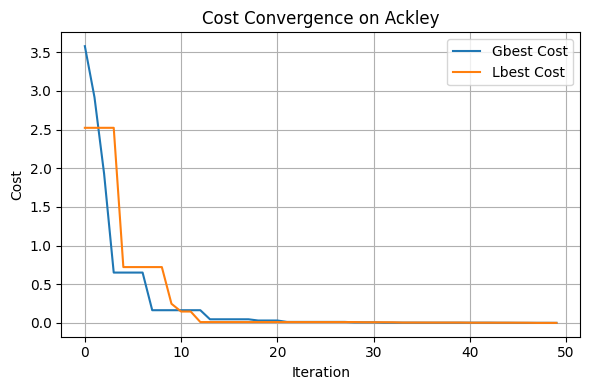

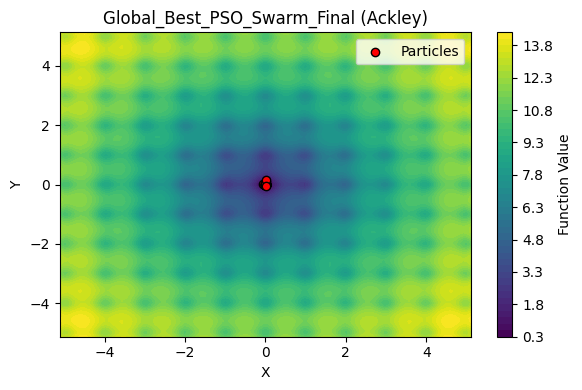

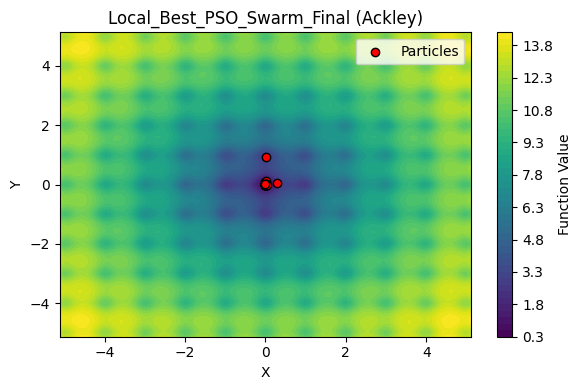


[Results: Rosenbrock]
  Gbest final cost: 0.001560, position: [1.0315275 1.0616689]
  Lbest final cost: 0.002088, position: [0.95450558 0.91064976]


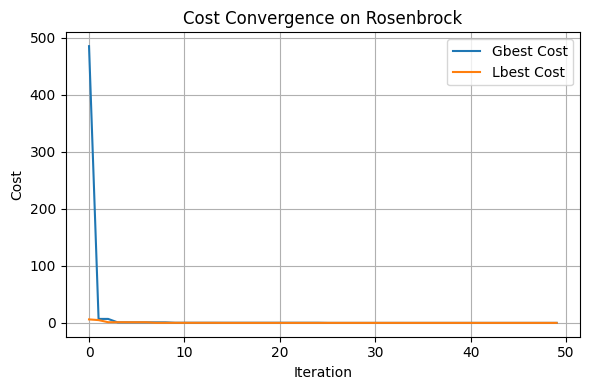

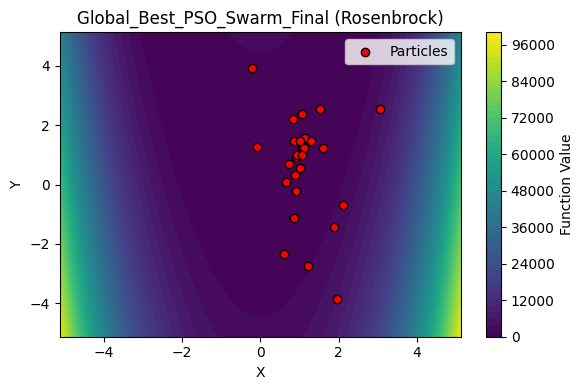

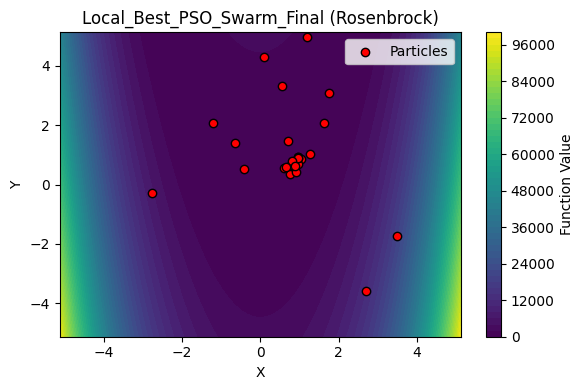


================= SUMMARY OF EXPERIMENT RESULTS =================
Function: Sphere
  Gbest final cost : 0.000000
  Lbest final cost : 0.000000
---------------------------------------------------------------
Function: Rastrigin
  Gbest final cost : 0.000014
  Lbest final cost : 0.027470
---------------------------------------------------------------
Function: Ackley
  Gbest final cost : 0.000388
  Lbest final cost : 0.000238
---------------------------------------------------------------
Function: Rosenbrock
  Gbest final cost : 0.001560
  Lbest final cost : 0.002088
---------------------------------------------------------------


In [46]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pyswarms as ps
from pyswarms.utils.functions.single_obj import sphere, rastrigin, ackley

##############################################################################
# 1. Define Benchmark Functions (including Rosenbrock)
##############################################################################
def rosenbrock(x):
    """
    Rosenbrock function in n dimensions.
    x is a 2D array of shape (n_particles, dimensions).
    Returns a 1D array of cost values (one per particle).
    """
    return np.sum(
        100.0 * (x[:, 1:] - x[:, :-1]**2.0)**2.0 + (1 - x[:, :-1])**2.0, axis=1
    )

benchmark_functions = {
    "Sphere":     sphere,
    "Rastrigin":  rastrigin,
    "Ackley":     ackley,
    "Rosenbrock": rosenbrock,
}

##############################################################################
# 2. PSO Parameters and Bounds
##############################################################################
options = {
    'c1': 1.5,  # cognitive
    'c2': 1.5,  # social
    'w':  0.7,  # inertia weight
    'k':  5,    # for LocalBestPSO: number of neighbors
    'p':  2     # for LocalBestPSO: Euclidean distance
}
n_particles = 30
max_iter    = 50
dimensions  = 2  # Keep 2D so that swarm contour plots make sense

# Typical bounds for 2D test functions
min_bounds = [-5.12]*dimensions
max_bounds = [ 5.12]*dimensions
bounds = (min_bounds, max_bounds)

##############################################################################
# 3. Plotting Helpers: We'll save and optionally show each figure
##############################################################################
def plot_cost_history(cost_history_g, cost_history_l, func_name, output_prefix=""):
    """
    Plots the convergence curves for GlobalBestPSO and LocalBestPSO.
    Saves the figure to disk in both PNG and PDF.
    """
    plt.figure(figsize=(6,4))
    plt.plot(cost_history_g, label='Gbest Cost')
    plt.plot(cost_history_l, label='Lbest Cost')
    plt.title(f"Cost Convergence on {func_name}")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    filename_base = f"{output_prefix}{func_name}_cost_convergence"
    plt.savefig(filename_base + ".png", dpi=150)
    plt.savefig(filename_base + ".pdf")

    plt.show()  # comment this out if you do NOT want a pop-up

def plot_2d_contour_and_swarm(func, func_name, bounds, positions, title="Swarm Final Positions", output_prefix=""):
    """
    Plots a 2D contour of 'func' and the final swarm positions (particles).
    positions: (n_particles, 2)
    Saves the figure to PNG and PDF as well.
    """
    if positions is None or positions.shape[1] != 2:
        return  # Only works for 2D

    # Meshgrid for contour
    x_min, x_max = bounds[0][0], bounds[1][0]
    y_min, y_max = bounds[0][1], bounds[1][1]
    resolution = 100
    x_vals = np.linspace(x_min, x_max, resolution)
    y_vals = np.linspace(y_min, y_max, resolution)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Evaluate the function on the grid
    xy_grid = np.vstack([X.ravel(), Y.ravel()]).T
    Z = func(xy_grid).reshape(X.shape)

    # Plot contour
    plt.figure(figsize=(6,4))
    cp = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(cp, label='Function Value')
    plt.title(f"{title} ({func_name})")
    plt.xlabel('X')
    plt.ylabel('Y')

    # Scatter the swarm
    plt.scatter(
        positions[:, 0],
        positions[:, 1],
        c='red', edgecolors='black',
        label='Particles'
    )
    plt.legend()
    plt.tight_layout()

    # Save the plot
    filename_base = f"{output_prefix}{func_name}_{title.replace(' ','_')}"
    plt.savefig(filename_base + ".png", dpi=150)
    plt.savefig(filename_base + ".pdf")

    plt.show()  # comment out if you don't need the GUI pop-up

##############################################################################
# 4. Experiment Runner
##############################################################################
def run_experiment(func, func_name, bounds=None):
    """
    Runs both GlobalBestPSO and LocalBestPSO on 'func'.
    Returns a dictionary with final best costs, positions, cost histories, etc.
    """
    # Global Best PSO
    gbest_optimizer = ps.single.GlobalBestPSO(
        n_particles=n_particles,
        dimensions=dimensions,
        options=options,
        bounds=bounds
    )
    gbest_cost, gbest_pos = gbest_optimizer.optimize(func, iters=max_iter, verbose=False)
    gbest_history = gbest_optimizer.cost_history

    # Final swarm positions from pos_history
    if len(gbest_optimizer.pos_history) > 0:
        gbest_swarm_positions = gbest_optimizer.pos_history[-1]
    else:
        gbest_swarm_positions = None

    # Local Best PSO
    lbest_optimizer = ps.single.LocalBestPSO(
        n_particles=n_particles,
        dimensions=dimensions,
        options=options,
        bounds=bounds
    )
    lbest_cost, lbest_pos = lbest_optimizer.optimize(func, iters=max_iter, verbose=False)
    lbest_history = lbest_optimizer.cost_history

    if len(lbest_optimizer.pos_history) > 0:
        lbest_swarm_positions = lbest_optimizer.pos_history[-1]
    else:
        lbest_swarm_positions = None

    print(f"\n[Results: {func_name}]")
    print(f"  Gbest final cost: {gbest_cost:.6f}, position: {gbest_pos}")
    print(f"  Lbest final cost: {lbest_cost:.6f}, position: {lbest_pos}")

    return {
        'gbest_cost'   : gbest_cost,
        'gbest_pos'    : gbest_pos,
        'gbest_history': gbest_history,
        'gbest_swarm'  : gbest_swarm_positions,
        'lbest_cost'   : lbest_cost,
        'lbest_pos'    : lbest_pos,
        'lbest_history': lbest_history,
        'lbest_swarm'  : lbest_swarm_positions
    }

##############################################################################
# 5. Main Script: Run + Plot + Save Figures
##############################################################################
if __name__ == "__main__":
    results = {}

    # Optional prefix for filenames if you like
    output_prefix = ""  # e.g., "pso_" or "my_results_"

    for func_name, func in benchmark_functions.items():
        # Run experiment
        outcome = run_experiment(func, func_name, bounds=bounds)
        results[func_name] = outcome

        # Plot cost convergence and save
        plot_cost_history(
            cost_history_g=outcome['gbest_history'],
            cost_history_l=outcome['lbest_history'],
            func_name=func_name,
            output_prefix=output_prefix
        )

        # If we have 2D, plot final swarm positions on a contour
        if dimensions == 2:
            # Global Best swarm
            plot_2d_contour_and_swarm(
                func=func,
                func_name=func_name,
                bounds=bounds,
                positions=outcome['gbest_swarm'],
                title="Global_Best_PSO_Swarm_Final",
                output_prefix=output_prefix
            )
            # Local Best swarm
            plot_2d_contour_and_swarm(
                func=func,
                func_name=func_name,
                bounds=bounds,
                positions=outcome['lbest_swarm'],
                title="Local_Best_PSO_Swarm_Final",
                output_prefix=output_prefix
            )

    # Print a summary
    print("\n================= SUMMARY OF EXPERIMENT RESULTS =================")
    for func_name, info in results.items():
        print(f"Function: {func_name}")
        print(f"  Gbest final cost : {info['gbest_cost']:.6f}")
        print(f"  Lbest final cost : {info['lbest_cost']:.6f}")
        print("---------------------------------------------------------------")


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pyswarms as ps
from pyswarms.utils.functions.single_obj import sphere, rastrigin, ackley

# Define or import your Rosenbrock if needed
def rosenbrock(x):
    return np.sum(
        100.0 * (x[:, 1:] - x[:, :-1]**2.0)**2.0 + (1 - x[:, :-1])**2.0,
        axis=1
    )

# Dictionary of benchmarks
benchmark_functions = {
    "Sphere":     sphere,
    "Rastrigin":  rastrigin,
    "Ackley":     ackley,
    "Rosenbrock": rosenbrock,
}

# PSO settings
options = {
    'c1': 1.5,
    'c2': 1.5,
    'w':  0.7,
    'k':  5,
    'p':  2
}
n_particles = 30
max_iter    = 50
dimensions  = 2

bounds = ([-5.12]*dimensions, [5.12]*dimensions)

# Dictionary to store results
results = {}

for func_name, func in benchmark_functions.items():
    # --- Global Best PSO ---
    gbest_optimizer = ps.single.GlobalBestPSO(
        n_particles=n_particles,
        dimensions=dimensions,
        options=options,
        bounds=bounds
    )
    gbest_cost, gbest_pos = gbest_optimizer.optimize(func, iters=max_iter, verbose=False)
    gbest_hist = gbest_optimizer.cost_history

    # --- Local Best PSO ---
    lbest_optimizer = ps.single.LocalBestPSO(
        n_particles=n_particles,
        dimensions=dimensions,
        options=options,
        bounds=bounds
    )
    lbest_cost, lbest_pos = lbest_optimizer.optimize(func, iters=max_iter, verbose=False)
    lbest_hist = lbest_optimizer.cost_history

    # Store in a dictionary for easy plotting & summary
    results[func_name] = {
        'Gbest_cost': gbest_cost,
        'Gbest_pos' : gbest_pos,
        'Gbest_hist': gbest_hist,
        'Lbest_cost': lbest_cost,
        'Lbest_pos' : lbest_pos,
        'Lbest_hist': lbest_hist,
    }


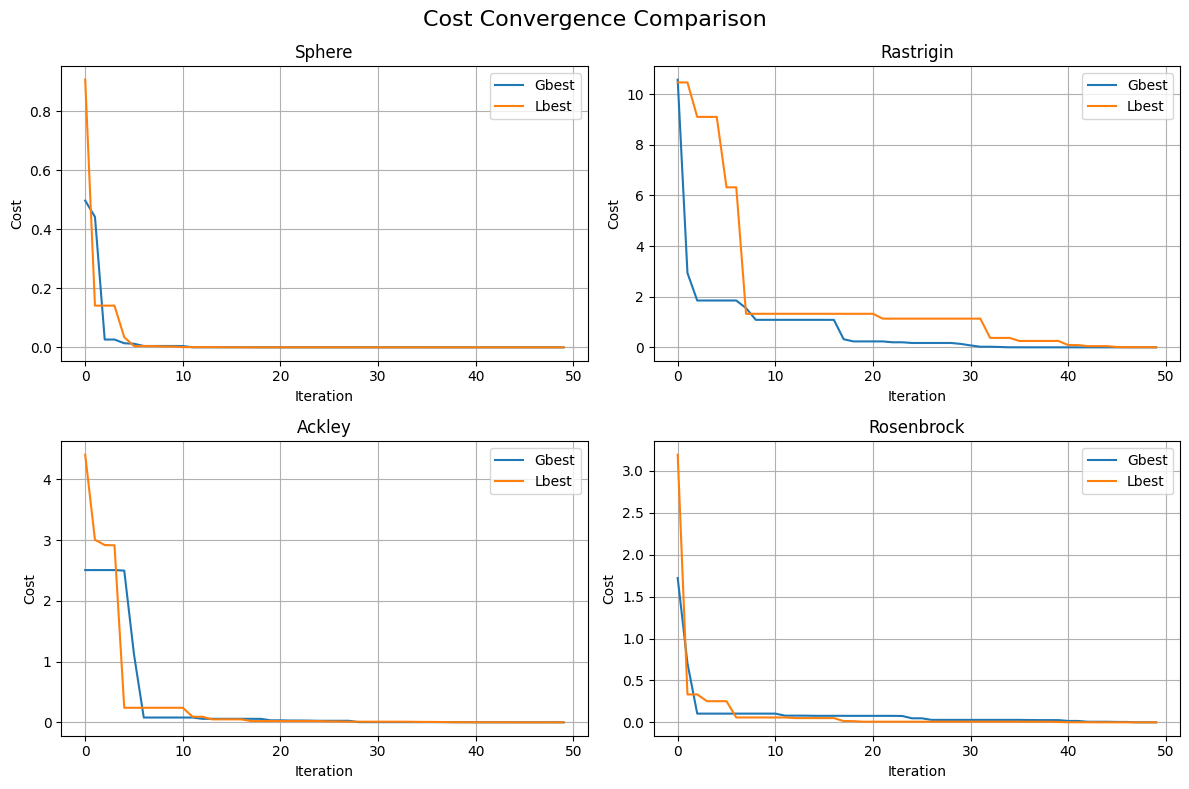

In [49]:
# Create a single figure for all convergence plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Cost Convergence Comparison", fontsize=16)

# A quick list of function names to keep consistent ordering:
func_names = list(results.keys())  # e.g. ["Sphere", "Rastrigin", "Ackley", "Rosenbrock"]

for idx, func_name in enumerate(func_names):
    # Row/Col in the 2x2 grid
    row = idx // 2
    col = idx % 2

    ax = axes[row, col]

    g_hist = results[func_name]['Gbest_hist']
    l_hist = results[func_name]['Lbest_hist']

    ax.plot(g_hist, label='Gbest', color='tab:blue')
    ax.plot(l_hist, label='Lbest', color='tab:orange')
    ax.set_title(func_name)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Cost")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


In [50]:
# Option A: Basic Print
print("\n================= FINAL RESULTS TABLE =================")
print(f"{'Function':<12} | {'Gbest Cost':>10} | {'Lbest Cost':>10} | {'Gbest Pos':>14} | {'Lbest Pos':>14}")
print("-"*70)

for func_name in func_names:
    g_cost  = results[func_name]['Gbest_cost']
    l_cost  = results[func_name]['Lbest_cost']
    g_pos   = results[func_name]['Gbest_pos']
    l_pos   = results[func_name]['Lbest_pos']

    # Convert positions to short strings
    g_pos_str = np.array2string(np.round(g_pos, 4), separator=',')
    l_pos_str = np.array2string(np.round(l_pos, 4), separator=',')

    print(f"{func_name:<12} | {g_cost:10.4f} | {l_cost:10.4f} | {g_pos_str:>14} | {l_pos_str:>14}")



================= FINAL RESULTS TABLE =================
Function     | Gbest Cost | Lbest Cost |      Gbest Pos |      Lbest Pos
----------------------------------------------------------------------
Sphere       |     0.0000 |     0.0000 | [-0.    , 0.0002] | [ 0.0002,-0.    ]
Rastrigin    |     0.0000 |     0.0007 | [ 0.0001,-0.0004] | [0.0015,0.0011]
Ackley       |     0.0011 |     0.0003 | [-0.0003,-0.0002] | [0.    ,0.0001]
Rosenbrock   |     0.0015 |     0.0008 | [0.9681,0.9349] | [1.0283,1.0567]


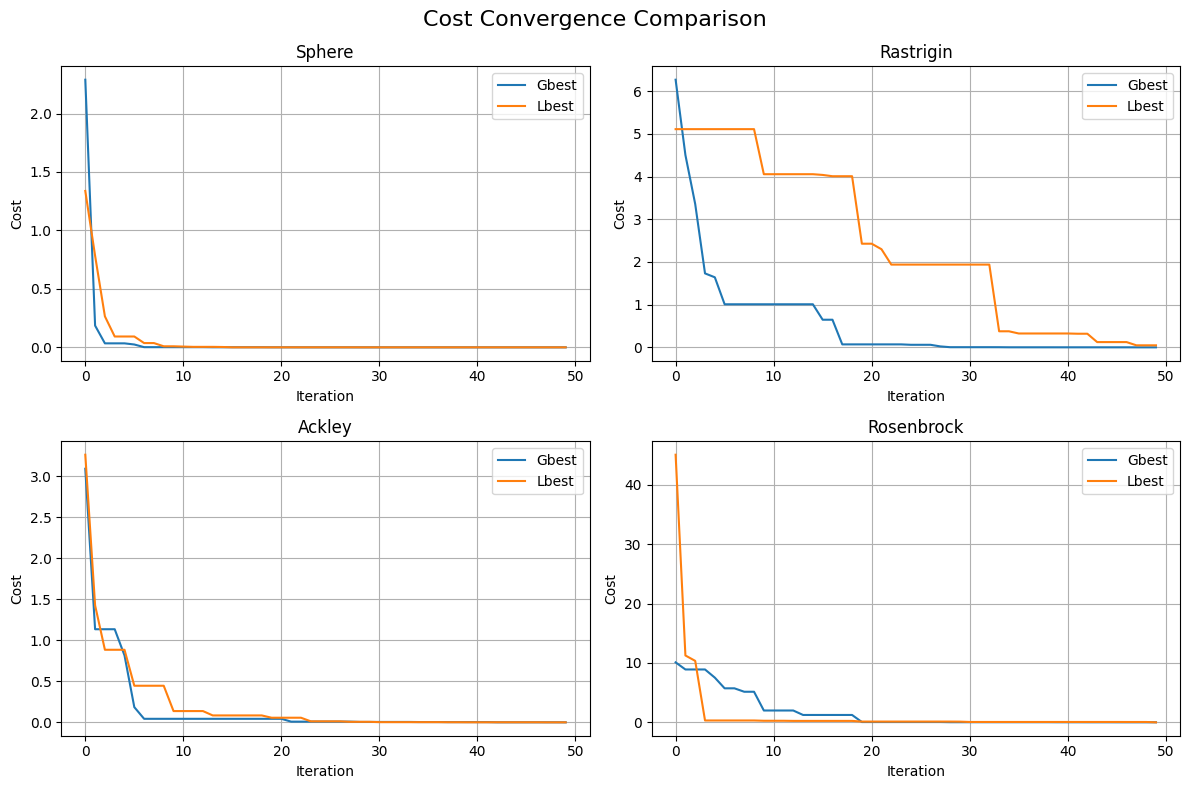

╒════════════╤══════════════╤══════════════╤═══════════════════╤═══════════════════╕
│ Function   │   Gbest Cost │   Lbest Cost │ Gbest Pos         │ Lbest Pos         │
╞════════════╪══════════════╪══════════════╪═══════════════════╪═══════════════════╡
│ Sphere     │     0        │     0        │ [-0.,-0.]         │ [-0.0002,-0.0006] │
├────────────┼──────────────┼──────────────┼───────────────────┼───────────────────┤
│ Rastrigin  │     0.000636 │     0.048008 │ [ 0.0017,-0.0006] │ [-0.0015,-0.0155] │
├────────────┼──────────────┼──────────────┼───────────────────┼───────────────────┤
│ Ackley     │     0.00033  │     0.000374 │ [-0.0001, 0.    ] │ [0.0001,0.    ]   │
├────────────┼──────────────┼──────────────┼───────────────────┼───────────────────┤
│ Rosenbrock │     0.009785 │     0.000145 │ [1.0961,1.2037]   │ [0.9896,0.98  ]   │
╘════════════╧══════════════╧══════════════╧═══════════════════╧═══════════════════╛


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pyswarms as ps
from pyswarms.utils.functions.single_obj import sphere, rastrigin, ackley
from tabulate import tabulate

def rosenbrock(x):
    return np.sum(
        100.0*(x[:,1:] - x[:,:-1]**2.0)**2.0 + (1 - x[:,:-1])**2.0, axis=1
    )

# Define function dictionary
benchmark_functions = {
    "Sphere": sphere,
    "Rastrigin": rastrigin,
    "Ackley": ackley,
    "Rosenbrock": rosenbrock,
}

options = {
    'c1': 1.5,
    'c2': 1.5,
    'w':  0.7,
    'k':  5,
    'p':  2
}
n_particles = 30
max_iter = 50
dimensions = 2
bounds = ([-5.12]*dimensions, [5.12]*dimensions)

if __name__ == "__main__":
    # 1. Run the experiments
    results = {}
    for func_name, func in benchmark_functions.items():
        # Gbest
        gbest_opt = ps.single.GlobalBestPSO(
            n_particles=n_particles,
            dimensions=dimensions,
            options=options,
            bounds=bounds
        )
        gbest_cost, gbest_pos = gbest_opt.optimize(func, iters=max_iter, verbose=False)
        gbest_hist = gbest_opt.cost_history

        # Lbest
        lbest_opt = ps.single.LocalBestPSO(
            n_particles=n_particles,
            dimensions=dimensions,
            options=options,
            bounds=bounds
        )
        lbest_cost, lbest_pos = lbest_opt.optimize(func, iters=max_iter, verbose=False)
        lbest_hist = lbest_opt.cost_history

        results[func_name] = {
            'Gbest_cost': gbest_cost,
            'Gbest_pos' : gbest_pos,
            'Gbest_hist': gbest_hist,
            'Lbest_cost': lbest_cost,
            'Lbest_pos' : lbest_pos,
            'Lbest_hist': lbest_hist,
        }

    # 2. Combined subplot for cost histories
    func_names = list(results.keys())  # e.g. ["Sphere","Rastrigin","Ackley","Rosenbrock"]
    fig, axes = plt.subplots(2, 2, figsize=(12,8))
    fig.suptitle("Cost Convergence Comparison", fontsize=16)

    for idx, f_name in enumerate(func_names):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]

        g_hist = results[f_name]['Gbest_hist']
        l_hist = results[f_name]['Lbest_hist']

        ax.plot(g_hist, label='Gbest', color='tab:blue')
        ax.plot(l_hist, label='Lbest', color='tab:orange')
        ax.set_title(f_name)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Cost")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # 3. Print a nice table using tabulate
    table_rows = []
    headers = ["Function", "Gbest Cost", "Lbest Cost", "Gbest Pos", "Lbest Pos"]

    for f_name in func_names:
        gcost = results[f_name]['Gbest_cost']
        lcost = results[f_name]['Lbest_cost']
        gpos  = np.round(results[f_name]['Gbest_pos'], 4)
        lpos  = np.round(results[f_name]['Lbest_pos'], 4)

        # Convert position arrays to strings
        gpos_str = np.array2string(gpos, separator=',')
        lpos_str = np.array2string(lpos, separator=',')

        table_rows.append([
            f_name,
            f"{gcost:.6f}",
            f"{lcost:.6f}",
            gpos_str,
            lpos_str
        ])

    # Choose your favorite format: "fancy_grid", "github", "latex", "psql"...
    print(tabulate(table_rows, headers=headers, tablefmt="fancy_grid"))
